# Color and Gradient

- Combine what you know about color and gradient thresholding to get the best of both worlds.
- Here's an example of how that might look:

!['Combined color and gradient thresholds for lane detection.'](color-and-gradient.png)


At this point, it's okay to detect edges around trees or cars.
- these lines can be mostly filtered out by applying a mask to the image and essentially cropping out the area outside of the lane lines. 
- It's most important that you reliably detect different colors of lane lines under varying degrees of daylight and shadow.

we can clearly see which parts of the lane lines were detected by the gradient threshold 
- and which parts were detected by the color threshold by stacking the channels and seeing the individual components. 

Create a binary combination of these two images to map out where either the color or gradient thresholds were met

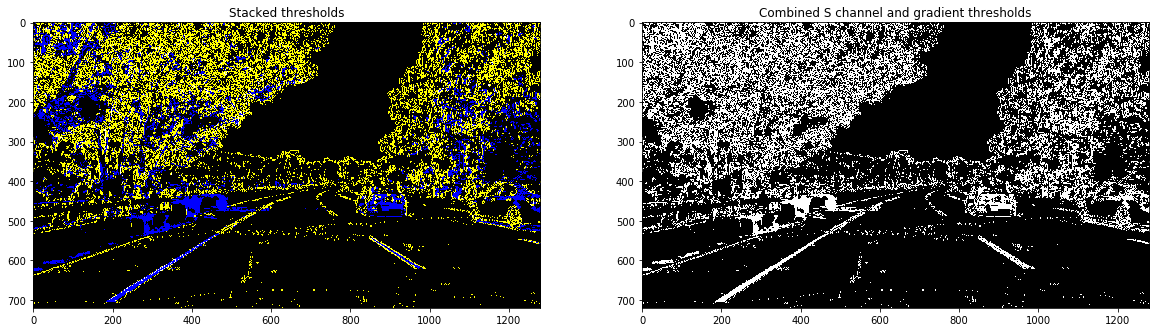

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def pipeline(img, s_thresh=(170, 255), x_thresh=(20, 100), sobel_ksize=3):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:, 2]
    
    # Standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    red = img[:,:, 1]
    green = img[:,:, 2]
    
    rg = (red + green) // 2
    # rg = red
        
    #  Sobel x. Take the derivative in x
    rg_x = cv2.Sobel(rg, cv2.CV_64F, 1, 0, ksize=sobel_ksize)
    abs_rg_x = np.absolute(rg_x) # Absolute x derivative to accentuate lines away from horizontal
    scaled_rg_x = np.uint8(255*abs_rg_x/np.max(abs_rg_x))
    
    # Threshold x gradient
    xbinary = np.zeros_like(scaled_rg_x)
    xbinary[ (scaled_rg_x >= x_thresh[0]) & (scaled_rg_x <= x_thresh[1])] = 1
    
    
    # Threshold saturation color channel
    sbinary = np.zeros_like(s_channel)
    sbinary[ (s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the 3 binary images, whose components you can see as different colors
    color_binary = np.dstack((xbinary, xbinary, sbinary)) * 255

    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(xbinary)
    combined_binary[(sbinary == 1) | (xbinary == 1)] = 1
    
    return color_binary, combined_binary

image = mpimg.imread('bridge_shadow.jpg')
color_binary, combined_binary = pipeline(image)

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')            